# QTR example code
|Image Size|MAC #|projection #|Method|
|------|---|---|---|
|30 by 30|3|6|QTR|

In [1]:
from IPython.display import HTML, display
from PIL import Image
import io
import base64
import math
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, radon
import cv2


In [2]:
def resize_with_aspect_ratio(img, max_size):
    width, height = img.size
    scale = min(max_size / width, max_size / height)
    new_size = (int(width * scale), int(height * scale))
    return img.resize(new_size, resample=Image.NEAREST)

def array_to_html_img_smart_resize(array, title, display_size=300):
    normalized = (array / np.max(array) * 255).astype(np.uint8)
    original_img = Image.fromarray(normalized).convert('L')
    display_img = resize_with_aspect_ratio(original_img, display_size)
    disp_buf = io.BytesIO()
    display_img.save(disp_buf, format='PNG')
    disp_b64 = base64.b64encode(disp_buf.getvalue()).decode('utf-8')
    disp_url = f"data:image/png;base64,{disp_b64}"

    return f"""
    <div class="image-container">
        <div class="image-title" style="width: {display_img.width}px;">{title}</div>
        <img src="{disp_url}" title="{title}">
        <a class="download-link" onclick="downloadImage('{disp_b64}', '{title}.png')">저장</a>
    </div>
    """

def make_image_table(arrays, titles, columns=2, display_size=300):
    assert len(arrays) == len(titles), "이미지 수와 제목 수가 같아야 합니다."
    rows = math.ceil(len(arrays) / columns)

    body_html = ""
    for r in range(rows):
        row_html = ""
        for c in range(columns):
            idx = r * columns + c
            if idx < len(arrays):
                row_html += f"<td style='text-align: center; vertical-align: top;'>{array_to_html_img_smart_resize(arrays[idx], titles[idx], display_size)}</td>"
            else:
                row_html += "<td></td>"
        body_html += f"<tr>{row_html}</tr>"

    html = f"""
   <style>
    .image-container {{
    text-align: center;
    }}
    .image-title {{
        text-align: center;
        font-size: 16px;
        font-weight: bold;
        margin-bottom: 6px;
    }}
    .download-link {{
        font-size: 12px;
        color: gray;
        background: rgba(255,255,255,0.8);
        padding: 2px 4px;
        border-radius: 4px;
        text-decoration: none;
        visibility: hidden;
        display: inline-block;
        margin-top: 4px;
    }}
    .image-container:hover .download-link {{
        visibility: visible;
    }}
    </style>


    <table style="border-collapse: collapse; float: left;">
        {body_html}
    </table>
    <script>
    function downloadImage(base64Data, filename) {{
        const link = document.createElement('a');
        link.href = 'data:image/png;base64,' + base64Data;
        link.download = filename;
        document.body.appendChild(link);
        link.click();
        document.body.removeChild(link);
    }}
    </script>

    """
    display(HTML(html))

In [3]:
def add_QUBO(position, values, sinogram_values):
    linear = np.square(values) 
    tmp1 = values*np.transpose(values) 
    tmp2 = np.ones(np.size(position)) - np.eye(np.size(position)) 
    tmp3 = linear - 2*sinogram_values*values
    return np.triu(2*np.multiply(tmp1,tmp2)+np.diag(tmp3.flatten()))

"Image Sample <a class=""download-link"" onclick=""downloadImage('iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAAAAABcFtGpAAADeklEQVR4nO3dQYrbQBBAUU3IFfuUumSW3hihH0ktaXhvZWzigU8tikbu/CxTjfzpuvkvtj8925+pf+3lxArECsQKxArECsQKxArECn6WCcbO9/Zab9rlTVYgViBWIFYgViBWIFYgViDWMzb4ceC9I3v7dbu8yQrECsQKxArECsQKxArECsQK/i4nG19effv0yDfvdfYub7ICsQKxArECsQKxArECsQKx5p/Bjy+vvn16ne3T+HN2eZMViBWIFYgViBWIFYgViBWINWuDH5vvbe/tR3bqvd989jM2JisQKxArECsQKxArECsQKxDr2g1+5Pdm/Mp0+6+ds8ubrECsQKxArECsQKxArECsQKxZG/xY3ufIkzUmKxArECsQKxArECsQKxArEOvOX7Ie0e+Dn8tkBWIFYgViBWIFYgViBWIFYl2xwY/l/62PPLXvT/mYrECsQKxArECsQKxArECsQKxnnMGvr9nl9zJZgViBWIFYgViBWIFYgViBWFc8Bz++vNq2Tr3n/ci3OIO/gFiBWIFYgViBWIFYgViBWHeewa9nf+HOb55xum+yArECsQKxArECsQKxArECsZ72S9Z151Pofsn6i4gViBWIFYgViBWIFYgViPW0DX5sPrky9974I0xWIFYgViBWIFYgViBWIFYg1p0b/HjNPt6ZrECsQKxArECsQKxArECsQKy33gd/xIy7bUxWIFYgViBWIFYgViBWIFYg1nM3+PHqE3qTFYgViBWIFYgViBWIFYgViHXtbZLLZfdKdufcROk2yQuIFYgViBWIFYgViBWIFYj125+iGTf9XZMViBWIFYgViBWIFYgViBWI9Ya7aLY9839sNVmBWIFYgViBWIFYgViBWIFYVzxFc87zNHc58uzMh8kKxArECsQKxArECsQKxArECsQKxArECsQKxArECsQKxArECsS69gz+Pafx55y8f5isQKxArECsQKxArECsQKxArECsQKxArECsQKxArECsQKxArECsWWfwzzyNP/vk/cNkBWIFYgViBWIFYgViBWIFYs3f4Pfu7Wdv9evUe+hNViBWIFYgViBWIFYgViBWINadG/yMXX7u3v5hsgKxArECsQKxArECsQKxArGescHffwZ/NpMViBWIFYgViBWIFYgViBWIFYgViBWIFYgViBWIFYgViBWIFYi17PcPLws7DFt3QjcAAAAASUVORK5CYII=', 'Image Sample.png')"">저장"

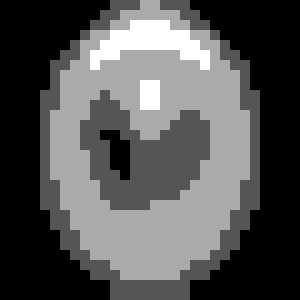

In [4]:
from random import *
num_qb = 3
nx= 30
pad = 3
num_pj = 6
phantom = shepp_logan_phantom() # 400 x 400
phantom = rescale(phantom, (nx-2)/400) 
phantom = np.pad(phantom, ((1,1),(1,1)))
sol_phantom = cv2.GaussianBlur(phantom, (7, 7), 0)
sol_phantom = sol_phantom/np.max(sol_phantom)*(num_qb) 
sol_phantom = np.round(sol_phantom, 0)

make_image_table([sol_phantom ], ["Image Sample"], columns=1)


fn_phantom = np.pad(sol_phantom, ((pad,pad),(pad,pad)))

dtheta = 180/(num_pj)
max_angle = 180
tnp = max_angle/dtheta
theta = np.arange(0, 180, dtheta)

"Variance plot <a class=""download-link"" onclick=""downloadImage('iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAAAAABcFtGpAAAEHElEQVR4nO3dQW7bMBRAQafovWWf3N3VG4LQVJRkFG9WgRMrxQMXPywt/Twutf396rXzu/6O8/y64Hf8N4oFigWKBYoFigWKBYoFigV+Hhd4D37d57Xnzhl9r/Nm+VYWKBYoFigWKBYoFigWKBYoFvj9uGlu/xm8tsZ5+/KtLFAsUCxQLFAsUCxQLFAsUKw7J/j3zn30jf8bYHSV5/Srx+JZvpUFigWKBYoFigWKBYoFigWKdf0pmvf00qOd9zXmZ2xGU/2RWb6VBYoFigWKBYoFigWKBYoFigUOjdTvwWW2wdQ8+iWjc/Bu9IlXf+9erSxQLFAsUCxQLFAsUCxQLFCsc0/RvHmXfTStH/nTYTswt4+usneWb2WBYoFigWKBYoFigWKBYoFinTvBP/l0zOqzM35fySOT/kcrCxQLFAsUCxQLFAsUCxQLFAv8w3C9nfZJ0fnJmjW/48i/vpUFigWKBYoFigWKBYoFigWKdcYe/Ht65n3ve+efKB19d83u+ZrzNK0sUCxQLFAsUCxQLFAsUCxQrDMm+OdDzWf+a5+mOuJ/JbSyQLFAsUCxQLFAsUCxQLFAsa7/JOvI/CTM/NOo8/l+zWkb391vZYFigWKBYoFigWKBYoFigWKdcQ5+G7w2n679SU3z2Xt+ZT/f7u9oZYFigWKBYoFigWKBYoFigWLd+UzW54F7v49m+b1/EVxxcr6VBYoFigWKBYoFigWKBYoFinXnBL/mDP122p0oj2hlgWKBYoFigWKBYoFigWKBYn3HBL9N98fnr32nVhYoFigWKBYoFigWKBYoFijWnRP869L7QB45f+9aWaBYoFigWKBYoFigWKBYoFjfdopmZLv9pI5rZYFigWKBYoFigWKBYoFigWJdNcFvfNeX1WdnfOf9yJOpWlmgWKBYoFigWKBYoFigWKBY507wr52T7/znrp3b1+zVt7JAsUCxQLFAsUCxQLFAsUCxvvcUzcb3fh9N3Hfdn6aVBYoFigWKBYoFigWKBYoFinXVE50eS56i5FdZs2vvO/mtLFAsUCxQLFAsUCxQLFAsUKwz9uBfO0+1773KtZ5LztO0skCxQLFAsUCxQLFAsUCxQLHAPxxI2Xb+3P13d1+z8/7RygLFAsUCxQLFAsUCxQLFAsW6/pOsr8Fr91uz8/7RygLFAsUCxQLFAsUCxQLFAsUChz4Uun3lbvzqnfePVhYoFigWKBYoFigWKBYoFigWWHRbl43fsWaqH92z5nXac1pbWaBYoFigWKBYoFigWKBYoFhg+Y0ZtwvuDD+fzFfP7R+tLFAsUCxQLFAsUCxQLFAsUCxw4q3Vt9Ou/Nq5B79aKwsUCxQLFAsUCxQLFAsUCxQL/HznE53uut5cKwsUCxQLFAsUCxQLFAsUCxTrsd8fDHx05Vz2AUMAAAAASUVORK5CYII=', 'Variance plot.png')"">저장"

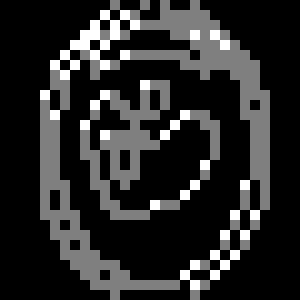

Variance of sample:  302.0


In [5]:
#diff_image
var_x = np.abs(np.diff(sol_phantom))
var_y = np.abs(np.diff(sol_phantom, axis=0))
var_x =  np.pad(var_x, ((0,0),(1,0)))
var_y = np.pad(var_y, ((1,0),(0,0)))
sum_of_var = var_x+var_y
Fin_Var = np.sum(var_x)+np.sum(var_y)
make_image_table([sum_of_var], ["Variance plot"], columns=1)
print("Variance of sample: ", Fin_Var)

"Image Sample <a class=""download-link"" onclick=""downloadImage('iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAAAAABcFtGpAAADN0lEQVR4nO3dwU7bQBRAUbfqL85X+ie7gkWjkXOb2J6gczaFUIJ09RZPY2y2DQAAAAAAAICn/druMJ79wj77j9MvnOn3HT/0U4kViBWIFYgViBWIteqeNQ5fOLTfuXCZrECsQKxArECsQKxArECs1ZbScfTC8XK6r7CcmqxArECsQKxArECsQKzgz3ai8c+/D1/ob3XozH3LZAViBWIFYgViBWIFYt18njUePph8/g7Tg64TFi6TFYgViBWIFYgViBWIFYh101I6Zi9Ml9G+OB6+1ZlXX01WIFYgViBWIFYgViDWxXvWOPj8+4UzLoBO3/vw1986kxWIFYgViBWIFYgViHXTnjW2FU0PujqTFYgViBWIFYgViBWIFYi1yh0W3dOPsbuFyQrECsQKxArECsQKxLpmzxr5O763pjuOCcfru5vJCsQKxArECsQKxArEWu08a5+9sOZl2SmTFYgViBWIFYgViBWIFYh1zW/+jYcPZg6P255fTvfXn2/n8O8SYgViBWIFYgViBWKtcvi3X/BWV54jmqxArECsQKxArECsQKxVbxrYDx/34aaBH0OsQKxArECsQKxArECsVZfSMXvkyRvufriCyQrECsQKxArECsQKxFrtb7Lu289gsgKxArECsQKxArECsT73yWzdlTfDmqxArECsQKxArECsQKxArOWX0vGZp4ImKxArECsQKxArECsQ6+InhrzvySHPe+EZI54YcgmxArECsQKxArECsX7wRdZx5w83WYFYgViBWIFYgViBWIFYH3Mn69Saf9zCZAViBWIFYgViBWIFYl1zkXW6FK2xJO3vv8JrsgKxArECsQKxArECsQKxArECsQKxArECsQKxArECsS4+/Pv/Wy5O8MYbKh6YrECsQKxArECsQKxArECsQKxArECsQKxArECsQKybzrNuPdc68xzri8kKxArECsQKxArECsQKxLp5KT1eRl/fUqcr55lPIDZZgViBWIFYgViBWIFYq+xZJ+xbt+xXX0xWIFYgViBWIFYgViDWanvWledZZzJZgViBWIFYgViBWIFYgViBWIFYgViBWIFYgViBWIFYAAAAAAAAAGyn+Av8wDqou/UdlgAAAABJRU5ErkJggg==', 'Image Sample.png')"">저장","Sinogram <a class=""download-link"" onclick=""downloadImage('iVBORw0KGgoAAAANSUhEUgAAADIAAAEsCAAAAACk/78yAAACH0lEQVR4nO1aS0sDMRBO47T2jVaQomgv4smDh3ry/3tRFEVBEFTwAZb6oD6qVlsvMzl8xcMuNE03M5dvmPTbzHRIMpNdY1RUVFRUVIKQ3JilxLjCeC0Dv4w2+SxWKZOn0Bh3lXHEuCQDnfSzKCV1XtZEWWesMd7IwCNjsLHYDFGozUpRLJuMn4xlGeh5dUwpSYV2WMmLZQEOLUmpaTEGG4vNEIW2WBmI5Rse5vKy7dWxyCm0DMvDPDO+M1ZxIVkvjlmlJBSqYSUvS2oe194iY7Cx2AxRSI6irliG8AtZWa4st14cs3FTqAdNkVsf+f/6KOvFMauUhEJ1Vh5w5AkN1dBjyRKFirj1fcAvZA2aplfHIqeQ9D4XYnmDMrAgA32vjikldQHfEMsllIGu2tBr22lUfU2xVGDL+5EBbax85qWDfW0FrlxdJ1wOPZbIKdTHhrcKb67cnjjn1bHIKTSAf93lpYGvn4ahx5LJra+EO1wNt75c6LFETqESFncWUukeqlXfNI6kgliKUO25hI1CjyVLFLpnZQMvItyduIg2vDNyitXxNccXrj296/OZl1OsLopQTLjq4iX9LEpJKrQPbwHNLhxJbgu8ZQw2Fhs3hQ7gysK0weCqiz2vjkVOIVHORDlhbMHHLubQq2ORU8jA1Z45ZnzFj47OvTqmlNSpHIlyBIY7/IDJJp7EKCV1Xpx0IR9XZlZisRmiqKioTFT+AKPKVskZ9IPyAAAAAElFTkSuQmCC', 'Sinogram.png')"">저장"

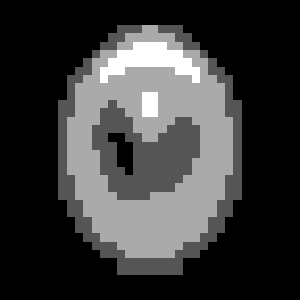
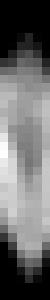

In [6]:
from random import *
sino = radon(fn_phantom, theta)
make_image_table([fn_phantom, sino], ["Image Sample", "Sinogram"], columns=2)

"Noisy Sinogram <a class=""download-link"" onclick=""downloadImage('iVBORw0KGgoAAAANSUhEUgAAADIAAAEsCAAAAACk/78yAAACKUlEQVR4nO1aSUtDMRCOcVxqXVFEcT3oQT14FA/+fgURRFAEwRW17q202kWrl5kcPvHwHjTGZObyDZN+rzOETCaTGKOioqKiohKEdP2wDDBOMV7IwCejzf4vVimdp9AP7gz8YlyU+/z/opTc87IgyiIstRsZeGIMNhYbEYU2WekXywpjjXFMBl68OqaUrELrOJXDjJOMFRlYYgw2FhsRhTZgATnpYfwSw5pXxxKnUJEVQVOHymBUBma9OqaUrEJDrAyK5ZxxjvFDBroZg43FRkQhyXBlsbQYG4zTBvYo68UxmzaF2nCcNU3GXsY+AxNlvThmlZI39VUMTN0zbm9ToccSE4XkXPsqlkf42A2W6daLYzZtCs2zciyWElQGrhuovb5/UsAXcLMq4C725tWxxCnUAzWd6/HVcYlNeHUscQo9QCHgeuFyvSFloc5L4BSSTCdLzfUq7rBtWws9lpgoJK28Kqa+It5/DIQeS0wUquKBdwT2KJf63r06ppSsQk1MfRZ6F+6j7dBjiYlCdWy1fvx2vi2GHktMFLpiZdlADmxhTiyFHkviFCphAS9Xik3oYbi+uvXimE2bQqesDGGGa+MNbzn0WGKi0A5UBmYLnki4qu/Sq2NKySq0jY9bVqGH4abygDHYWGyM7/oORTlhbECVYfa8OpY4hUSRnp/ZhXtC6QuZI6+OKSX3VH6Jsg+GWxnQJ5p/MS8G19o145n5L7HYiCgqKiodlW+Ua1cSGL3cbAAAAABJRU5ErkJggg==', 'Noisy Sinogram.png')"">저장",

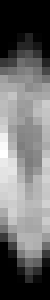

In [7]:
# 95 이상 106 미만의 정수 난수 생성 (105 포함되도록)
random_matrix = np.random.uniform(0.95, 1.05, size=(nx+2*pad, num_pj))
noisy_sinogram = sino*random_matrix
make_image_table([noisy_sinogram], ["Noisy Sinogram"], columns=2)

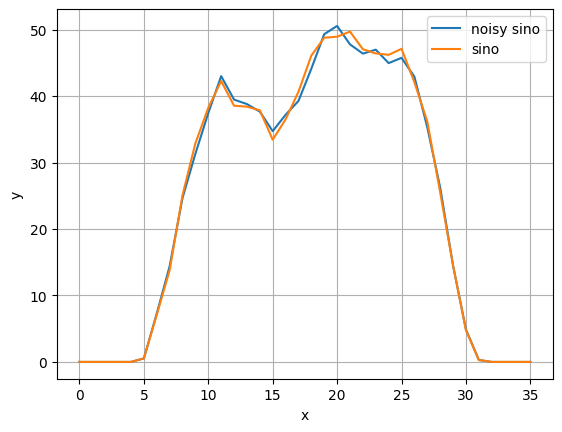

In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(noisy_sinogram[:,1] ,label='noisy sino')
plt.plot(sino[:,1],label='sino')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
Q1 = np.zeros((num_qb*nx**2,num_qb*nx**2))
 
Fin_Min = 0
num_row = num_qb*nx
for sino_ny in range(0,int(tnp)):
    print(sino_ny)
    temp_theta = [theta[sino_ny]]
    for sino_nx in range(0,nx+2*pad):
        Arr_pos = np.array([])
        Arr_val = np.array([])
        for j in range(0,nx):
            for i in range(0,nx):
                G = np.zeros((nx+2*pad,nx+2*pad))
                G[i+pad][j+pad] = 1
                R = radon(G, temp_theta)
                for qb in range(0, num_qb):
                    Arr_pos = np.append(Arr_pos, np.array(i+num_row*(j)))
                    Arr_val = np.append(Arr_val, np.array(R[sino_nx][0]))
        sino_val = noisy_sinogram[sino_nx][sino_ny]
        Q1 = Q1 + add_QUBO(Arr_pos.reshape(-1,1), Arr_val.reshape(-1,1), sino_val)
        Fin_Min -= sino_val**2

0


c:\Users\KTJun\anaconda3\envs\ocean\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


1
2
3
4
5


In [10]:
T = np.zeros((num_qb*nx**2,1))
for j in range(0,nx):
    for i in range(0,nx):
        Val_fn_pt = fn_phantom[i+pad][j+pad]
        for k in range(0, num_qb):
            temp_val = divmod(Val_fn_pt,2)
            Val_fn_pt = temp_val[0]
            T[i*num_qb + j*num_qb*nx + k] = temp_val[1]
            
tmp1 = np.matmul(np.transpose(T),Q1)
tmp2 = np.matmul(tmp1,T)
print('Minimum value as our goal = ', Fin_Min)
print('By using the matrix Q, the obtained value x^TQx = ', tmp2.item())

Minimum value as our goal =  -198561.97028104746
By using the matrix Q, the obtained value x^TQx =  -170149.76058527193


In [11]:
def Q_mat(qubits,QM):
    max_d = format(len(str(qubits)), '02')
    
    # linear terms
    Q = {}
    for i in range(qubits): 
        linear_term = format(i + 1, max_d)
        exec("Q.update({('q%s','q%s'):%s})"%(linear_term, linear_term, format(QM[i][i])))

    # quadratic terms
    for i in range(qubits-1):
        for j in range(i+1,qubits):
            if QM[i][j] != 0:
                qdrt1 = format(i + 1, max_d)
                qdrt2 = format(j + 1, max_d)
                exec("Q.update({('q%s','q%s'):%s})"%(qdrt1,qdrt2,format(QM[i][j])))
    return Q

In [12]:
QM = Q1 
Q = Q_mat(num_qb*nx*nx, QM)

from dwave.system import LeapHybridSampler
sampler = LeapHybridSampler()
answer = sampler.sample_qubo(Q)

print(answer,'\n')

print('Target minimum energy = ', Fin_Min+Fin_Var)
print("Our minimum energy = ", answer.record[0][1])

  q0001 q0002 q0003 q0004 q0005 q0006 q0007 ... q2700         energy num_oc.
0     0     0     0     0     0     0     0 ...     0 -198545.740219       1
['BINARY', 1 rows, 1 samples, 2700 variables] 

Target minimum energy =  -198259.97028104746
Our minimum energy =  -198545.74021940597


In [13]:
data = answer.record[0][0]  

CT_phantom = np.zeros((nx,nx))
for j in range(0,nx):
    for i in range(0,nx):
        for k in range(0,num_qb):
            CT_phantom[i][j] = CT_phantom[i][j] + data[i*(num_qb) + j*(num_qb)*nx + k]

Error  = CT_phantom-sol_phantom

"CT image using a hybrid solver <a class=""download-link"" onclick=""downloadImage('iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAAAAABcFtGpAAAExklEQVR4nO3dQW7rNhRAUaXoFu1FWotMZ82EeOCtLeUXOGcU2I4VXHBAMxT9ddzq9e9Pz/HZlXPzsev8devV/ufECsQKxArECsQKxArECsQKvo5bPcaf5vn4O89+hpEViBWIFYgViBWIFYgViBWIFfx9XOaRZ9eP/OzzI9fdZWQFYgViBWIFYgViBWIFYgVi3T+Df4x7Ys7NOfru61bXuOOfCUZWIFYgViBWIFYgViBWIFYg1v0z+Nfmqvisz+9/rva9eN3qd99hZAViBWIFYgViBWIFYgViBWIF20vXj3E2/Ni8G3XlOV5j9/125+3vzOWNrECsQKxArECsQKxArECsQKzg6969M8/xd8/FT6u19d01/fn/AatnZ0ZWIFYgViBWIFYgViBWIFYg1l27aF6bs+HdnTXzOv9zcd3dzwaf2S9vZAViBWIFYgViBWIFYgViBWL95p2sz8VjfYV+9bp5p/s7O3B2GVmBWIFYgViBWIFYgViBWIFYwfaS9Guce8+r52eeZ89z9K83dsm/sxpvZAViBWIFYgViBWIFYgViBWLddSfr9/iG/TTJY3Ndft6Vs/tpYn5sxcgKxArECsQKxArECsQKxArEunYG/xhf18962V1Hnz8brMwr/j+fA8zgLyBWIFYgViBWIFYgViBWINa1++DPxWOrOfXuyvtq5/xqx8z35n75eT6++7oVIysQKxArECsQKxArECsQKxAr+A9Hs7w2V7t3Z9L9VJp5J/78uvkO2pmRFYgViBWIFYgViBWIFYgViHXFGvxj8diZT3qc97/0PTHHG/Px3T35P4ysQKxArECsQKxArECsQKxArGv3wb/G9fZ53btfo3/v0pFPubEGfwGxArECsQKxArECsQKxArF+8zz41xur7Od41+pqnr1a8Z8/Taz+H7DLyArECsQKxArECsQKxArECsS6fwZ/jnPl78XMfPdEm/nkyN2T5ld/S1/dN7ICsQKxArECsQKxArECsQKxrt0H/zXOhudnV+8372BfzcJ3d8SvHutnSP4wsgKxArECsQKxArECsQKxArGumME/x+9xmu9z3X3neVY/r6jP+9tX30LlO1kvJVYgViBWIFYgViBWIFYg1rWnST4Wc+rVyvt8XuR84Xn9frWD/TNnxM+MrECsQKxArECsQKxArECsQKy7ZvD9ZMa+Y2ZlNUfvd7J2RlYgViBWIFYgViBWIFYgViDWnzaDP8dn+5kw85+/Wr9f/X3uZL2UWIFYgViBWIFYgViBWIFY155Fc47PzmfCzO8yn1Sz2iU/fydr/6bYmZEViBWIFYgViBWIFYgViBWI9ZvnwfedNau7TOf7V+dr7J6G0xlZgViBWIFYgViBWIFYgViBWNeeJnmOz+7eoXqMu9XnnTXznpjV/bWfYWQFYgViBWIFYgViBWIFYgViBZ+e5B6r2fVqHX2eo6/OgVx9/+pq3807+2RmRlYgViBWIFYgViBWIFYgViDW/btoVlZ7z+dT21ez+tVO99398p+eyxtZgViBWIFYgViBWIFYgViBWL+5Br9r99ubjnE+ft16+4qRFYgViBWIFYgViBWIFYgViPVnrMHvmuftu/e03sHICsQKxArECsQKxArECsQKxDr2/QMQmrTELtBQdAAAAABJRU5ErkJggg==', 'CT image using a hybrid solver.png')"">저장","Error <a class=""download-link"" onclick=""downloadImage('iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAAAAABcFtGpAAAEt0lEQVR4nO3dQW5aSRRAUdLKvkKvDLyyfK8sPYsnpae6gg9u6ZwRwmBHVzUofh71f9wur3T9++g+/nT13HF5t3/e/Q/4PxErECsQKxArECsQKxArECv4eXmBY9yZz3v0Y/FotdN/BSsrECsQKxArECsQKxArECsQK/hxe/sOftd1c39/P+2qvZUViBWIFYgViBWIFYgViBWI9fpr8NenXCmf3zt/DvgYX/ccVlYgViBWIFYgViBWIFYgViDWO3fw98Vz/bfs7u///fvo9+J1z2ZlBWIFYgViBWIFYgViBWIFYp0xRXPdnEzf/ebpvOdfzcRcNuflz5uSt7ICsQKxArECsQKxArECsQKxzrgGfywezbMzq134fALN1zs+H9ijz58NHjnbxsoKxArECsQKxArECsQKxArEetUUzXVzRv05J0d+5HfM/5Z+rd7KCsQKxArECsQKxArECsQKxPq+c/D3zan22+J186T77gTOI6ysQKxArECsQKxArECsQKxArDN28NenzLXMszi3zd/88cBfm2f3Z1ZWIFYgViBWIFYgViBWIFYg1rnnwR/jNe75dJjduzc9Mk1/3l1craxArECsQKxArECsQKxArECsd97R6chXtndfN3826JM1vsl6KrECsQKxArECsQKxArECsc6dgz8Wz81nPs579PnEmK99+5/FO+55+n2ep5lZWYFYgViBWIFYgViBWIFYgVhnXIM/Nk+R2X3HfAp8v7fT7qz9I1fjraxArECsQKxArECsQKxArECs13+T9WMx4bI6n+aR+y49cnZl/30rVlYgViBWIFYgViBWIFYgViDWuVM01/GnqxMh+7TNPCczX9Ofn1v93V1WViBWIFYgViBWIFYgViBWINb3OA++293L9z36dfG/Be7odCqxArECsQKxArECsQKxArFev4M/8uzM7t57Pjmynz853xdqZmUFYgViBWIFYgViBWIFYgVinTsHf188+hjPfJx367tX2VfffZ3Psbnk77nOrKxArECsQKxArECsQKxArECsM3bw93EP/Gvxjt1r3PMufLWDn0+GX/3mz8WZlKZoTiVWIFYgViBWIFYgViBWINa5UzT3xR74c/NOrKv37s7OrCZhdt+7+i128KcSKxArECsQKxArECsQKxDrnfdknc1z8PM8zep18xz8PBFvB38qsQKxArECsQKxArECsQKxvtsO/hh/+sjpNV/zNJdx/n4+xXKXlRWIFYgViBWIFYgViBWIFYj1qrNojgdmYo5xP76aq19Nyf/aPCO+79ZXrKxArECsQKxArECsQKxArECsd54Hfyyemx2bV8/ncyVXnwP+PGV25ouVFYgViBWIFYgViBWIFYgViHXuaZLH4rnVfPvn4qzJ+Tuou6fFz9fbf2+eMNlZWYFYgViBWIFYgViBWIFYgVjfbQ7+nvfoq88Bt82zbfr/AuyysgKxArECsQKxArECsQKxArFeP0Vz2bwn68o8J7OadL+/dPr9i5UViBWIFYgViBWIFYgViBWI9X1Pkzzy3ZtW730XKysQKxArECsQKxArECsQKxDrndfgu3nfPn+n9dlzMjMrKxArECsQKxArECsQKxArEOuy7z/ea8CrqeA1+QAAAABJRU5ErkJggg==', 'Error.png')"">저장"

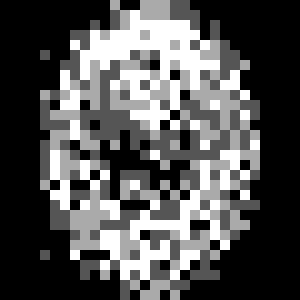
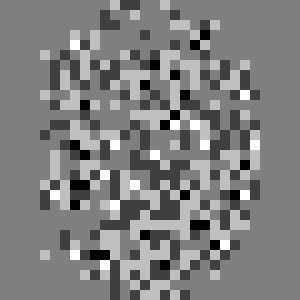

Error of solution:  378.0
Variance of solution:  1127.0


In [14]:
Error  = CT_phantom-sol_phantom
make_image_table([CT_phantom, Error-np.min(Error)], ["CT image using a hybrid solver", "Error"], columns=2)

print("Error of solution: ", np.sum(np.abs(CT_phantom-sol_phantom)))
sol_var_x = np.abs(np.diff(CT_phantom))
sol_var_y = np.abs(np.diff(CT_phantom, axis=0))
print("Variance of solution: ", np.sum(sol_var_x)+np.sum(sol_var_y))